In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, RocCurveDisplay


# Load Data

In [2]:
PATH_data = "../PyMethylProcess/GSE50660"
PATH_results = "logs"

batch_size = 64
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/chr5_smoking_train.pkl", colName="SMOKING").returnTensor_()

with open(os.path.join(PATH_data, "chr5_smoking_test.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Train and predict from input CpG data

In [3]:
## Remove samples with NA in target
# Train
y_train = train_tensor[1].detach().numpy()
mask_train = ~np.isnan(y_train)
X_train = train_tensor[0].detach().numpy()[mask_train]
y_train = y_train[mask_train]

# Test
y_test = test_dataset["pheno"]["SMOKING"].values
mask_test = ~np.isnan(y_test)
X_test = test_dataset["beta"][mask_test].values
y_test = y_test[mask_test]

# # Train RFregression model
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

# # Score on Test set
y_pred = classifier.predict_proba(X_test)[:,1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred)}")

# # save model
# outPath = f"logs/{name}/regression/"
# os.makedirs(outPath, exist_ok=True)
# pickle.dump(regr, open(f"{outPath}/RFregressor.sav", 'wb'))

ROC-AUC: 0.8074324324324325


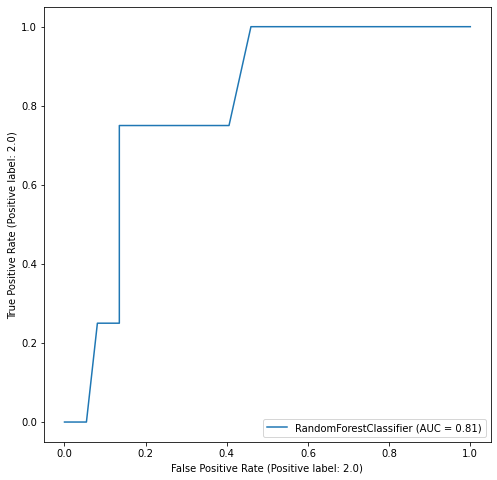

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax)
plt.show()


## Using only the best features

In [5]:
df_importances = pd.DataFrame([classifier.feature_importances_],columns=test_dataset["beta"].columns.tolist()).T
top100featuresNames = df_importances.sort_values(by=0, ascending=False)[:100].index.tolist()

idx_top100features = [df_importances.index.get_loc(i) for i in top100featuresNames]

ROC-AUC: 0.8716216216216217


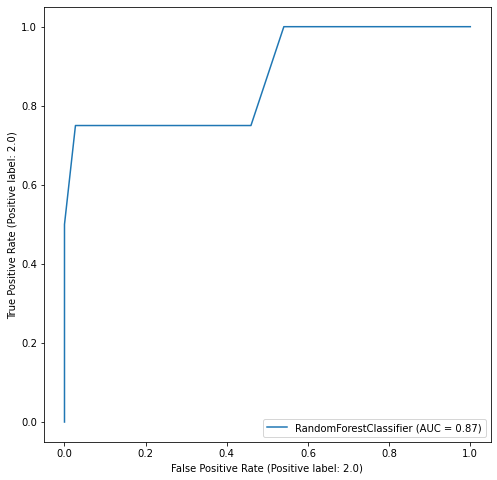

In [6]:
X_train_top = X_train[:,idx_top100features]
X_test_top = X_test[:, idx_top100features]
    
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train_top, y_train)

# # Score on Test set
y_pred = classifier.predict_proba(X_test_top)[:,1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred)}")

fig, ax = plt.subplots(figsize=(8,8))
RocCurveDisplay.from_estimator(classifier, X_test_top, y_test, ax=ax)
plt.show()